In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import friedmanchisquare
from scipy.io import savemat
import pickle as pkl

In [17]:
##session-1 data of EEG
data1=loadmat("../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess1.mat")
fvec=np.squeeze(data1["Freqs"])[3:30]

df=pd.read_excel('../ListROIs_DK.xlsx')

In [9]:
##EEG-modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


In [10]:
#lIST of all the regions name and their indices
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

In [18]:
##session 4, significant(pFDR<0.05) regions for the respective parameters in EEG and their indices
gei_regions=['cuneus L', 'cuneus R', 'inferiorparietal L', 'lateraloccipital L', 'precentral L']
gii_regions=['cuneus L', 'cuneus R', 'isthmuscingulate L', 'lingual L', 'parahippocampal R']
tau_e_regions=['supramarginal R']

gei_idx=[]
gii_idx=[]
tau_e_idx=[]

for idx, region in enumerate(all_regions):
    if region in gei_regions:
        gei_idx.append(idx)

for idx, region in enumerate(all_regions):
    if region in gii_regions:
        gii_idx.append(idx)

for idx, region in enumerate(all_regions):
    if region in tau_e_regions:
        tau_e_idx.append(idx)

print(gei_idx, gii_idx, tau_e_idx)

[6, 7, 14, 22, 48] [6, 7, 20, 26, 35] [63]


### Friedman Test on the significant regions

In [13]:
##Friedman test for gei
RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

for num in gei_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 0, :]  
        rest_values = x_rest_all[sess][num, 0, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)->4=sessions, 19=subjects
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])

    #highlighting region where p-val < 0.05
    region_name = all_regions[num]
    if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
        region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
        print(region_name)
        print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
        print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

    # print(region_name)
    # print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    # print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")


In [14]:
##Friedman test for gii
RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

mi_pvalues = []

for num in gii_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 1, :]  
        rest_values = x_rest_all[sess][num, 1, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    mi_pvalues.append(friedman_mi.pvalue)
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])


    # #highlighting region where p-val < 0.05
    # region_name = all_regions[num]
    # if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
    #     region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
    #     print(region_name)
    #     print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    #     print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

fdr_corr_p=fdrcorrection(mi_pvalues)[1]
# print(fdr_corr_p)
for num in fdr_corr_p:
    print(num)

    # print(region_name)
    # print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    # print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")


0.32145265214055896
0.32145265214055896
0.32145265214055896
0.32145265214055896
0.12965050142804896


In [ ]:
##Friedman test for tau_e
RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

for num in tau_e_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 2, :]  
        rest_values = x_rest_all[sess][num, 2, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])

    #highlighting region where p-val < 0.05
    region_name = all_regions[num]
    if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
        region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
        print(region_name)
        print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
        print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

    # print(region_name)
    # print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    # print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")


### group level parameters values distribution using BOX plots

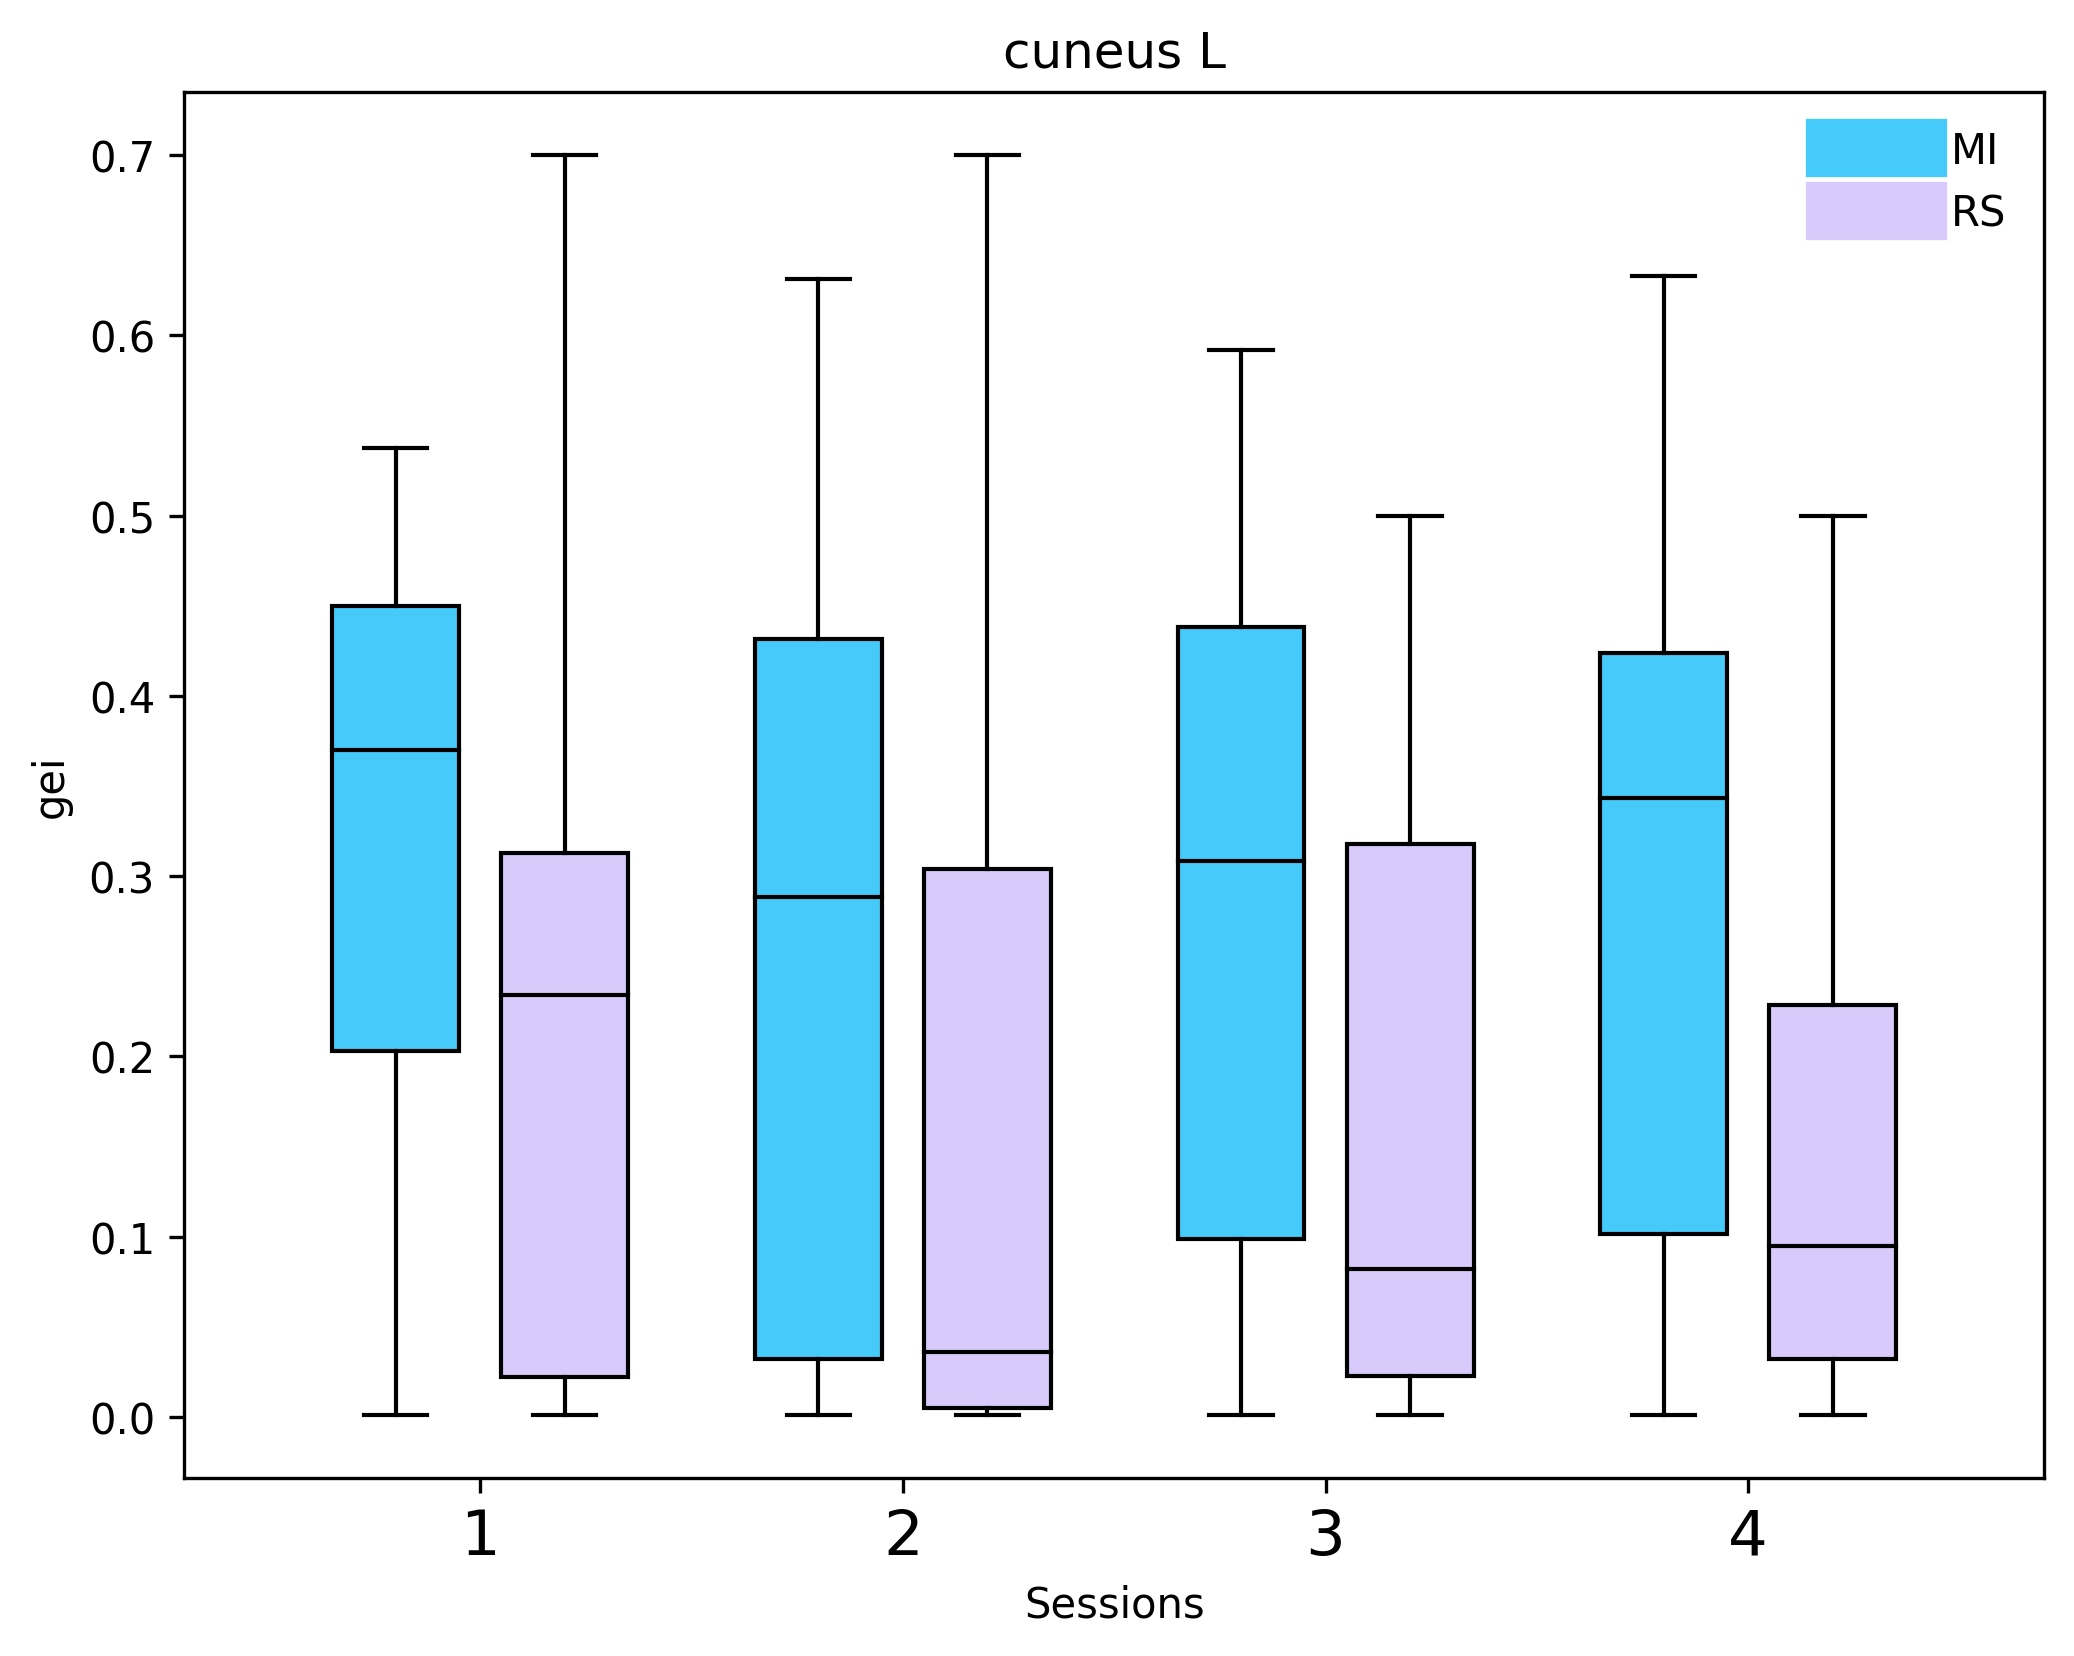

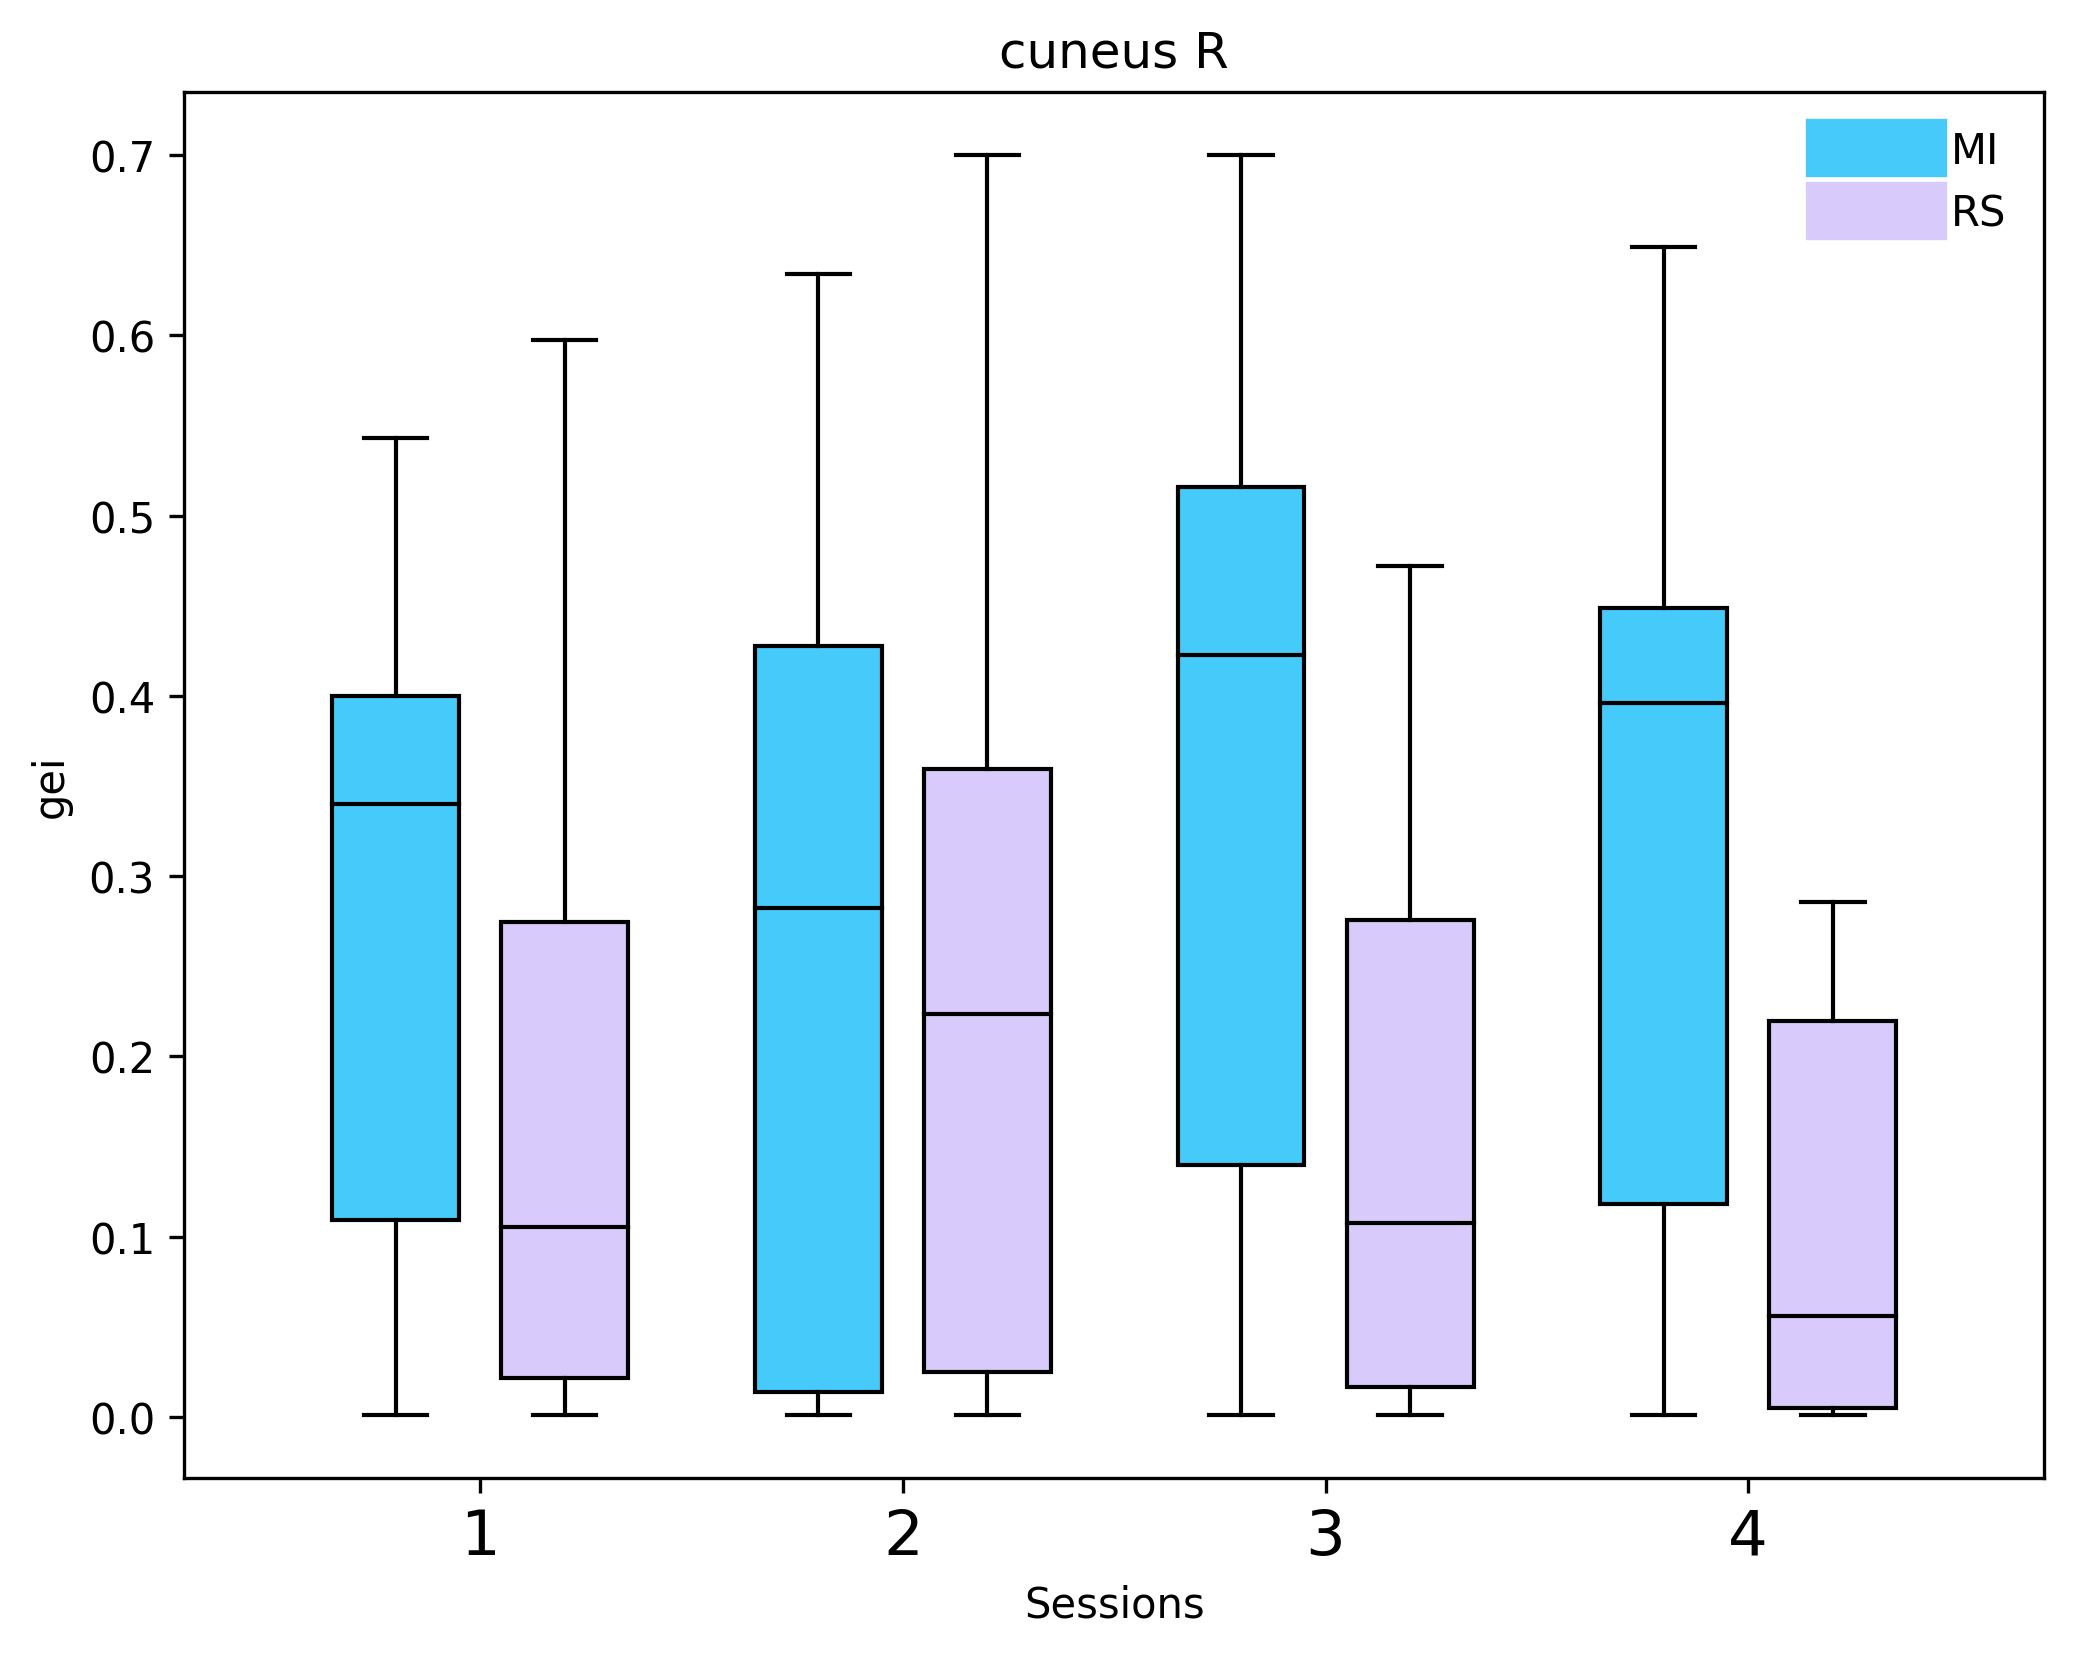

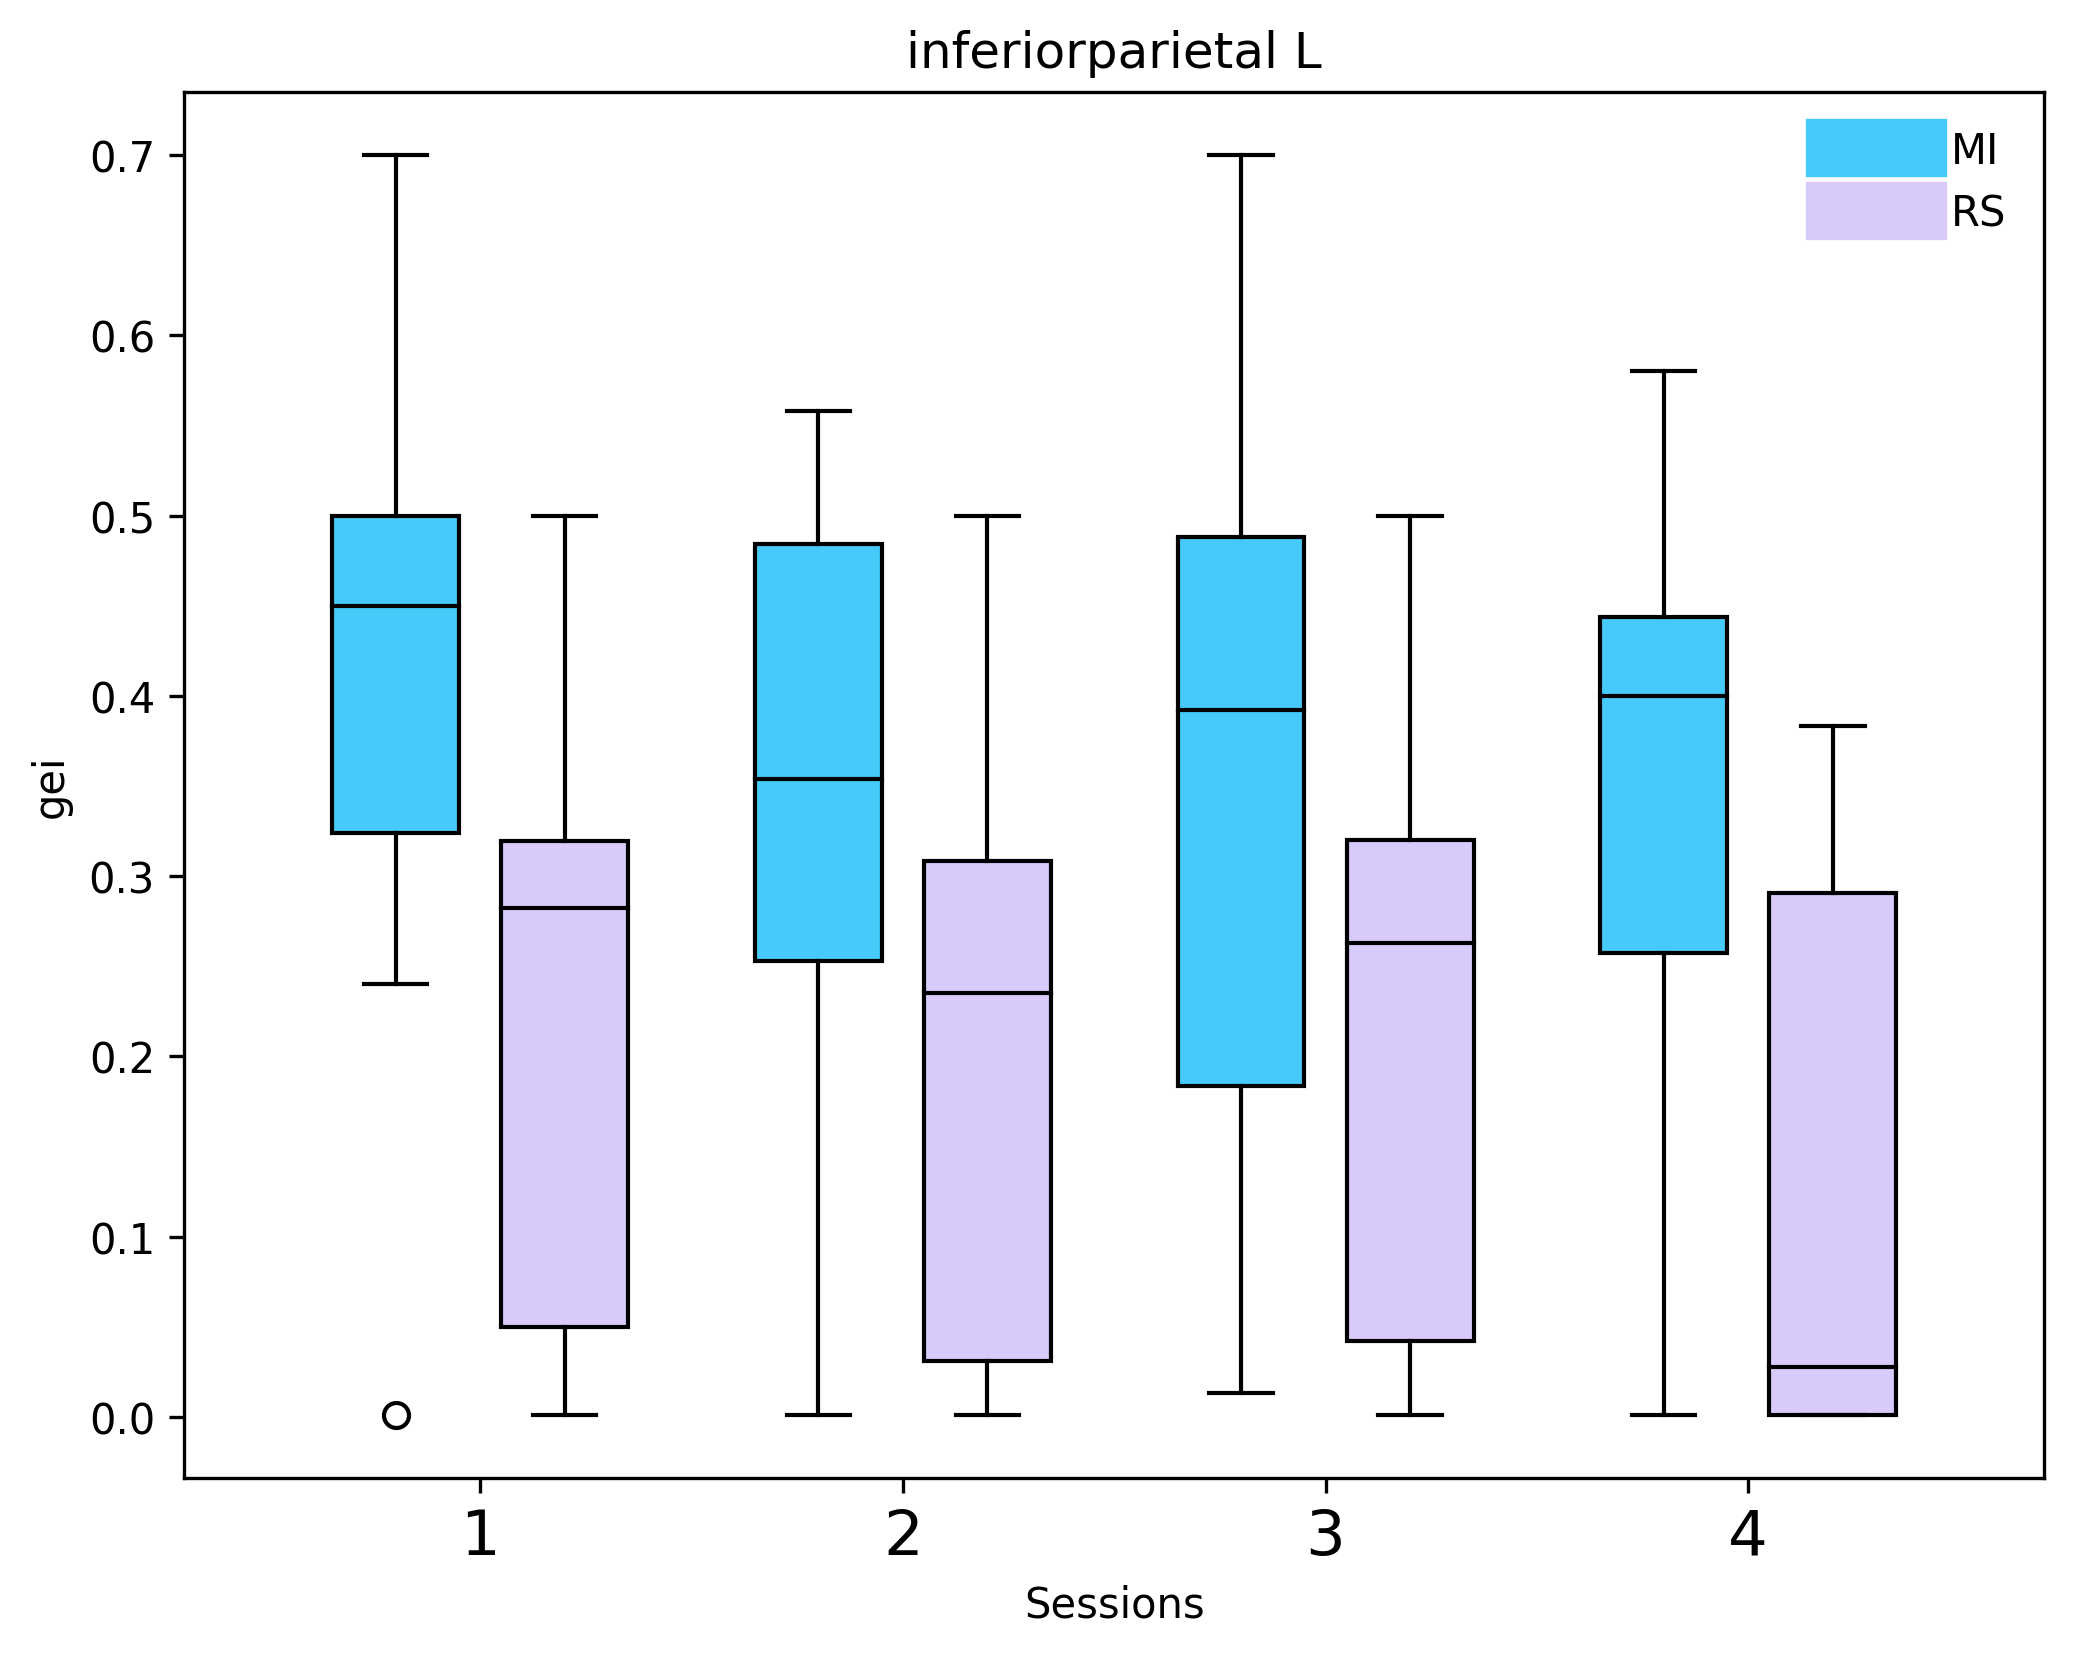

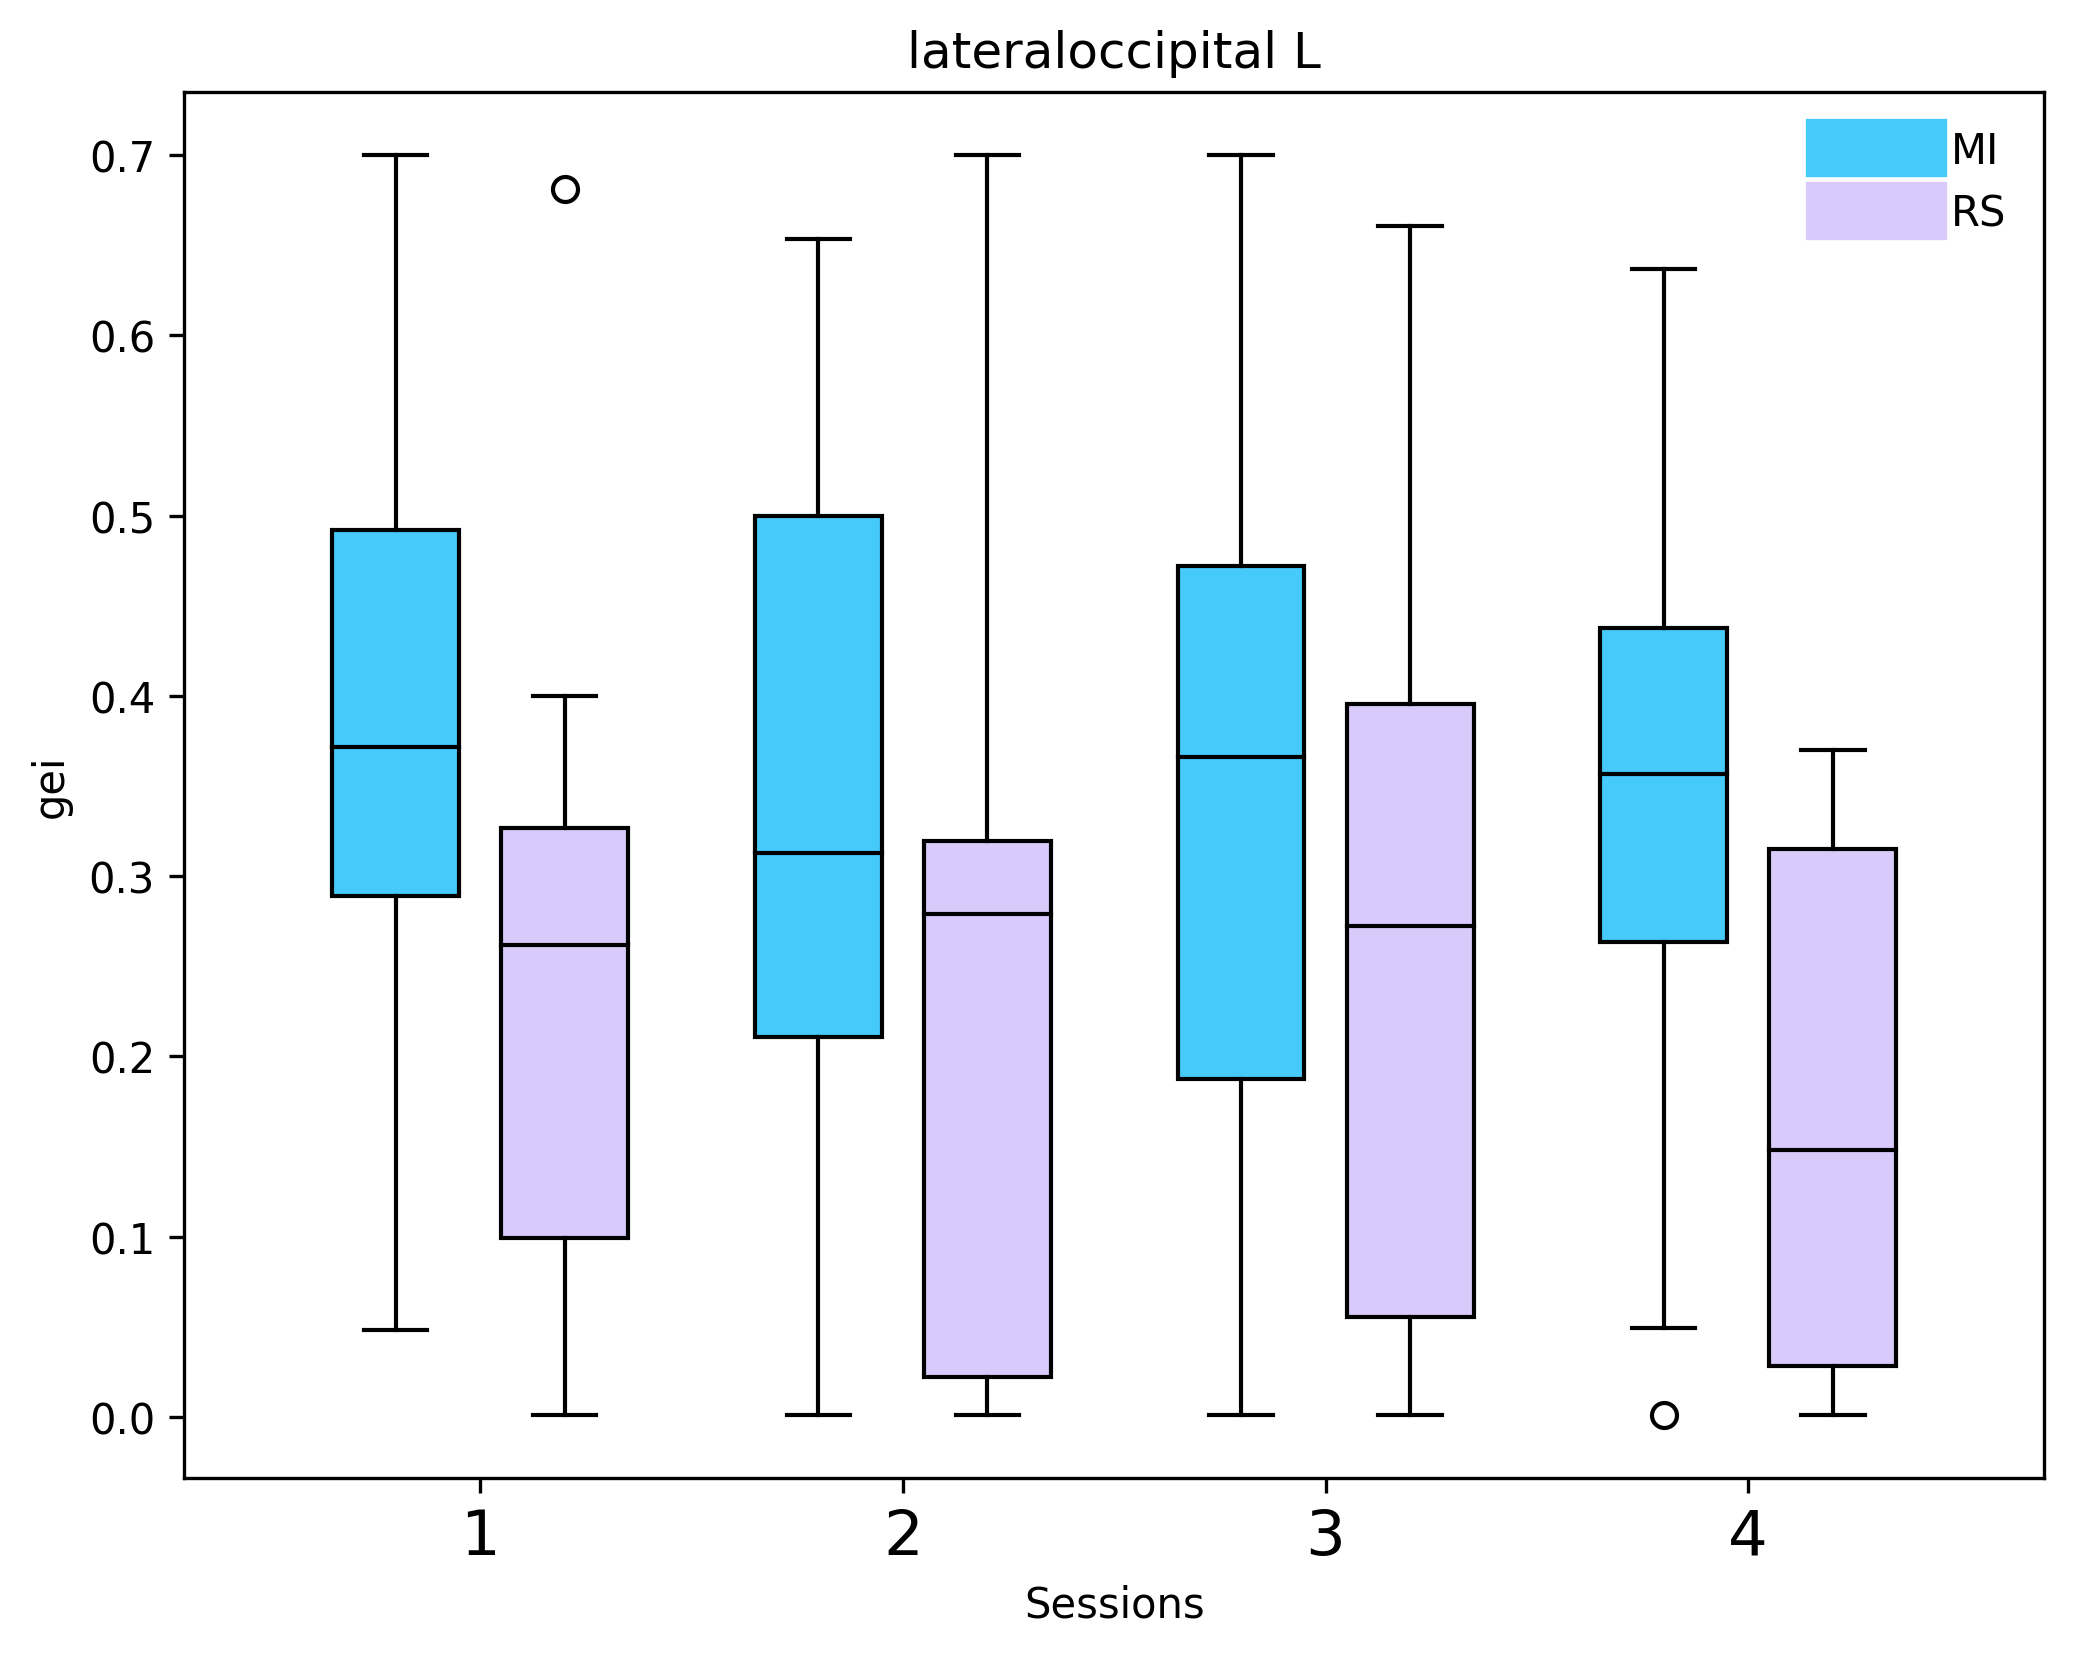

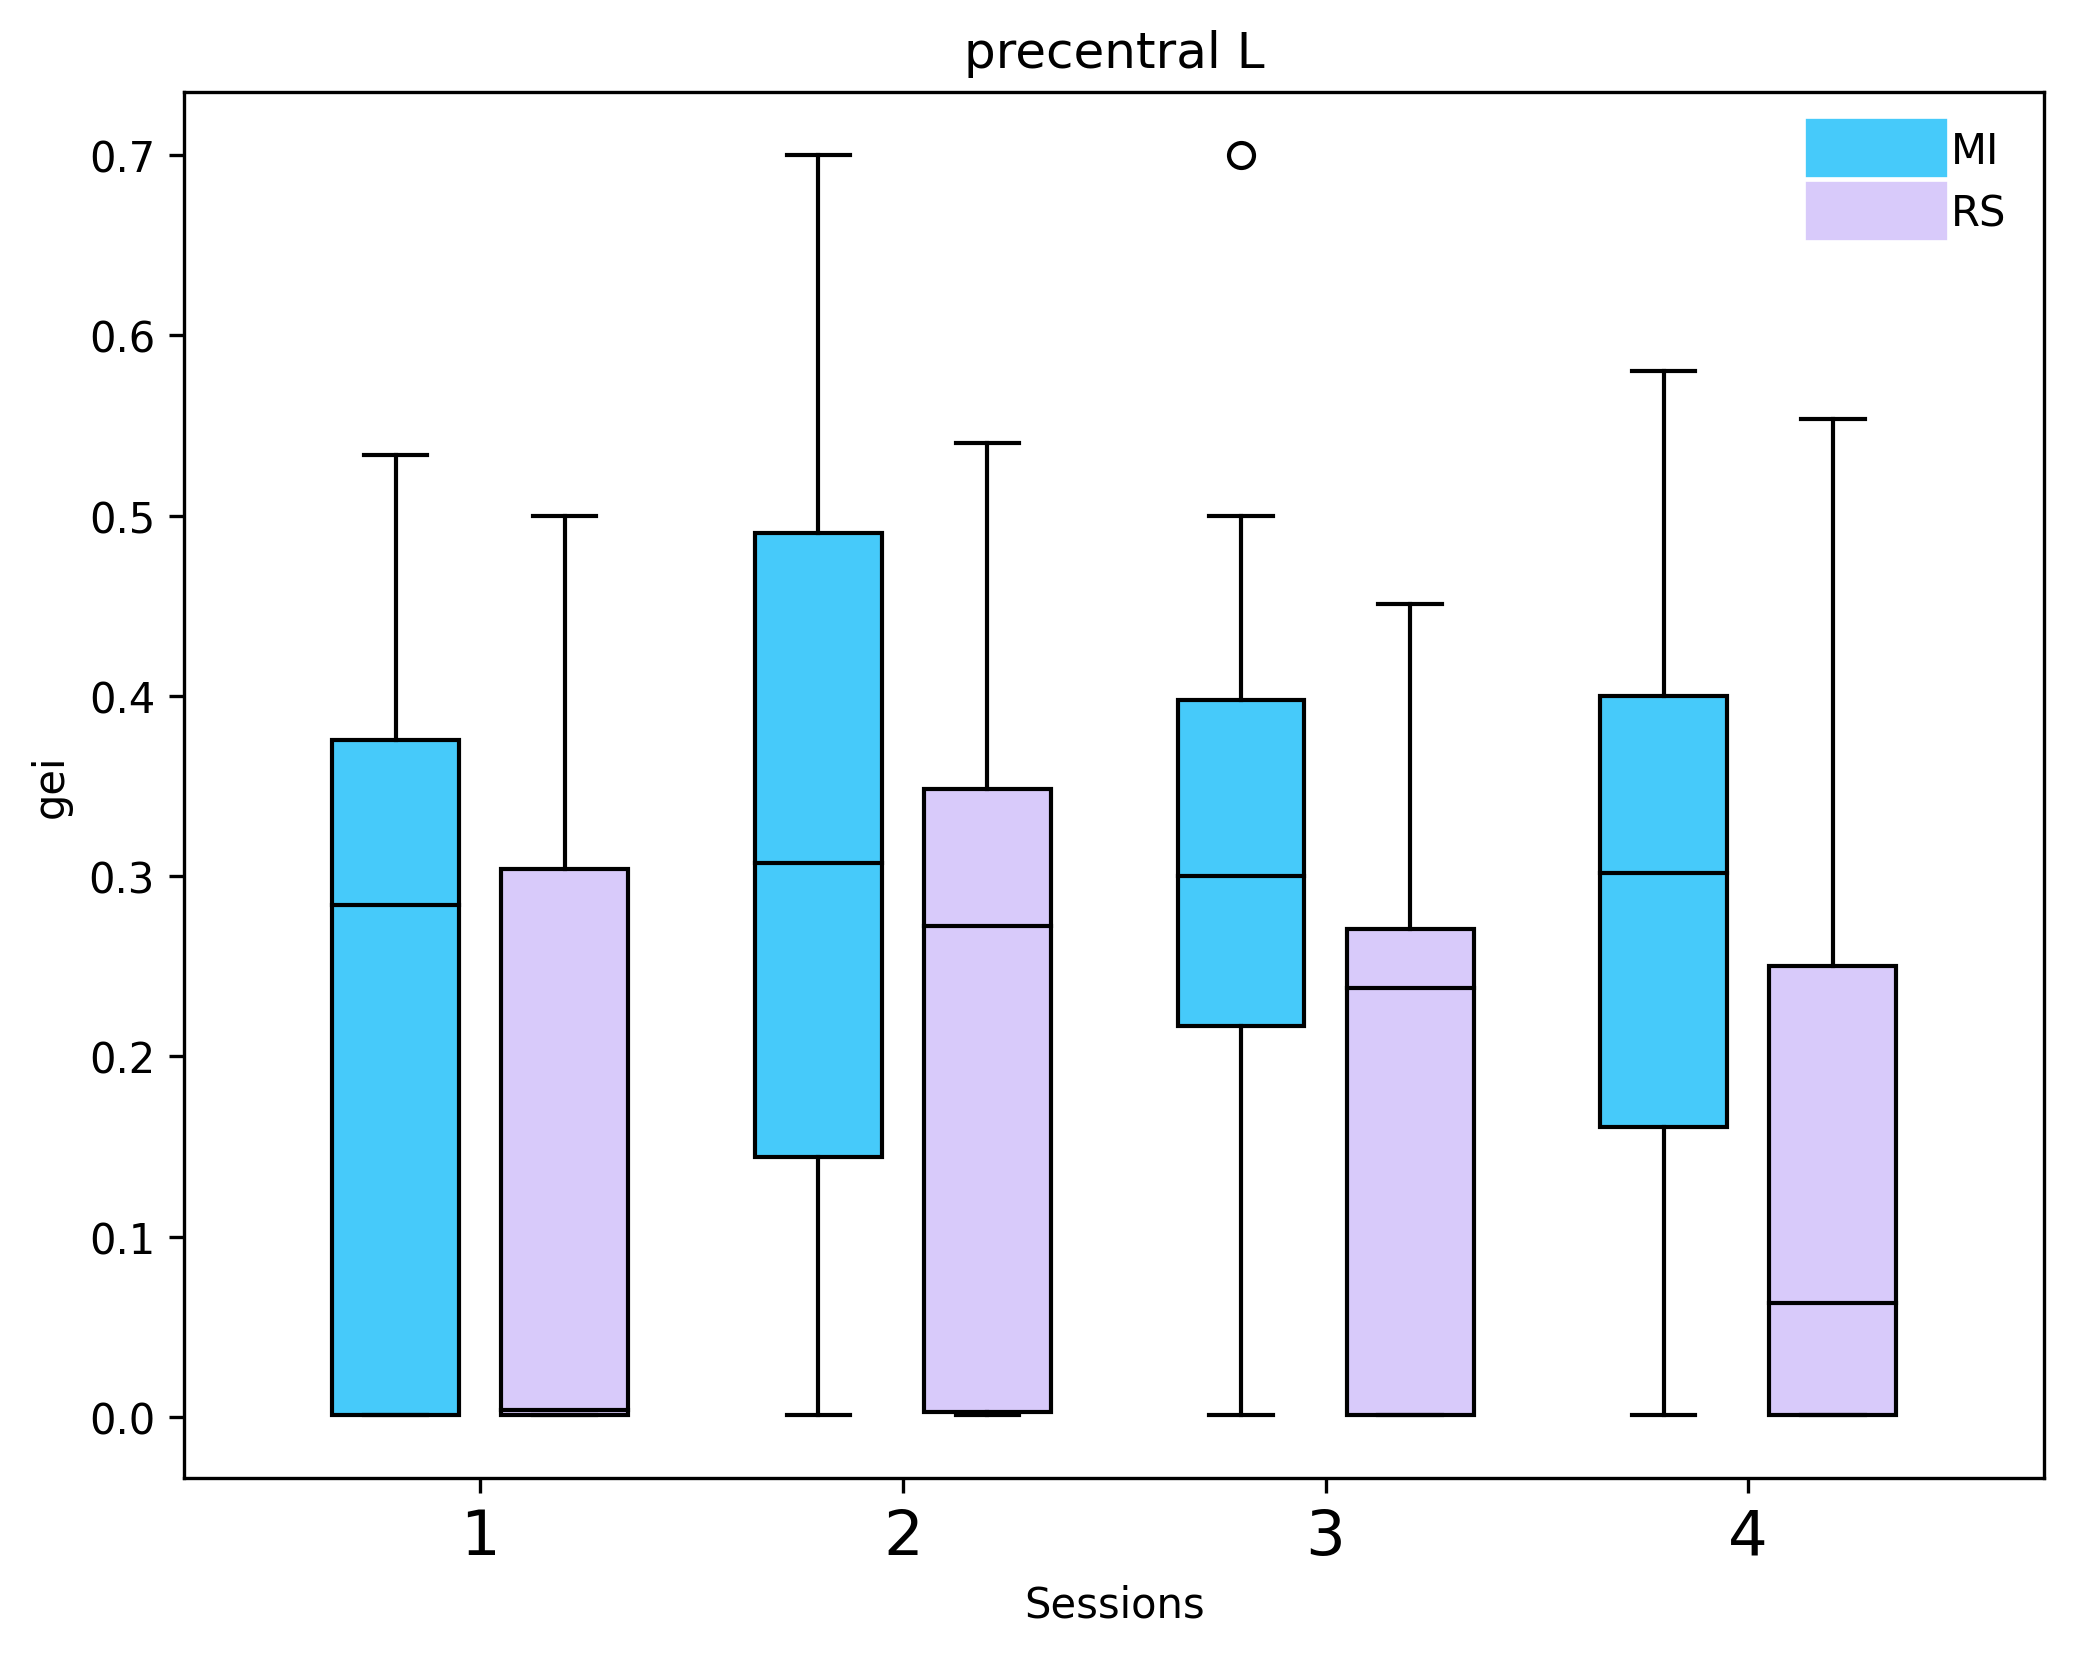

In [16]:
##for gei
for idx_region in gei_idx:
    sessions = range(1, 5)
    mi_values = [x_mi_all[i][idx_region, 0, :] for i in sessions]
    rest_values = [x_rest_all[i][idx_region, 0, :] for i in sessions]

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    colors = ['#46CAFA', '#D8CAFA']
    positions = []
    data = []
    box_colors = []

    for i, session in enumerate(sessions):
        positions.append(i-0.2) 
        data.append(mi_values[i])   
        box_colors.append(colors[0])
        
        positions.append(i+0.2) 
        data.append(rest_values[i])
        box_colors.append(colors[1])


    box = ax.boxplot(
        data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
    )


    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f"{all_regions[idx_region]}")
    ax.set_xlabel("Sessions")
    ax.set_ylabel("gei")
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels([str(s) for s in sessions], fontsize=15)
    ax.grid(False)

    legend_patches = [
        plt.Line2D([0], [0], color=colors[0], lw=14, label="MI"),
        plt.Line2D([0], [0], color=colors[1], lw=14, label="RS")
    ]
    ax.legend(handles=legend_patches, frameon=False)

    plt.show()


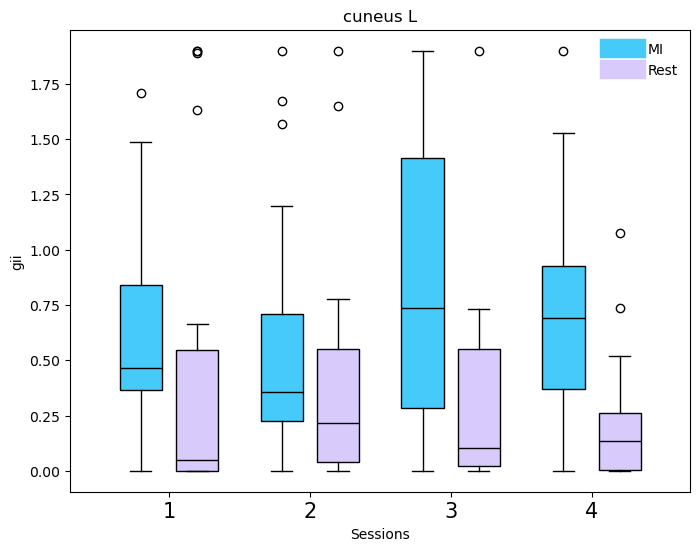

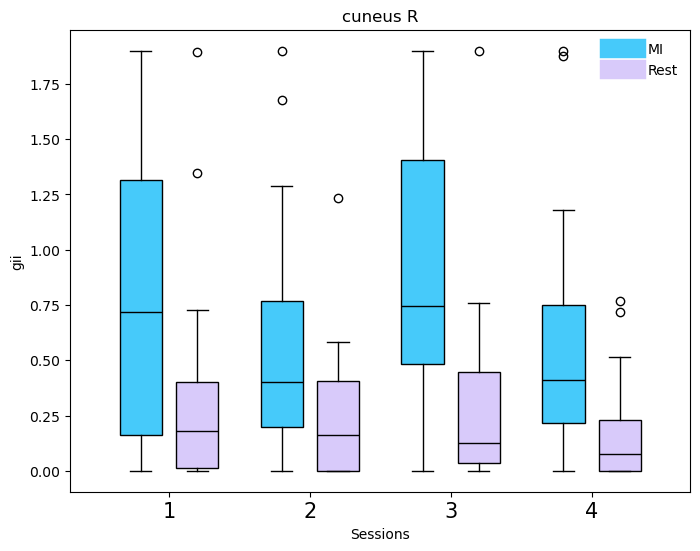

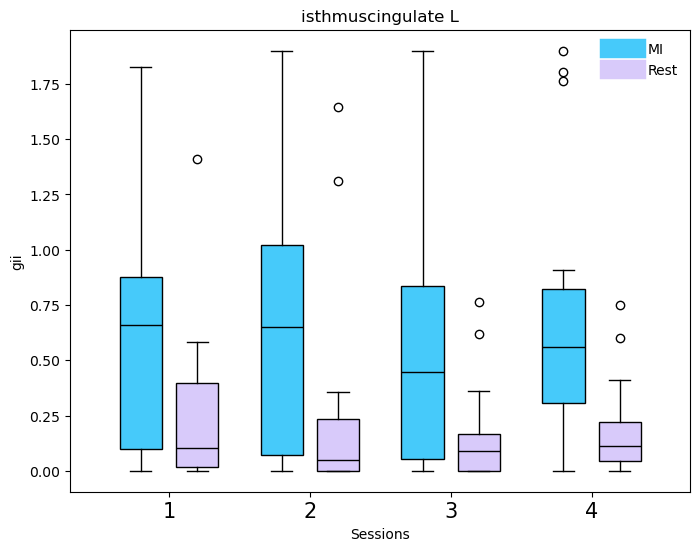

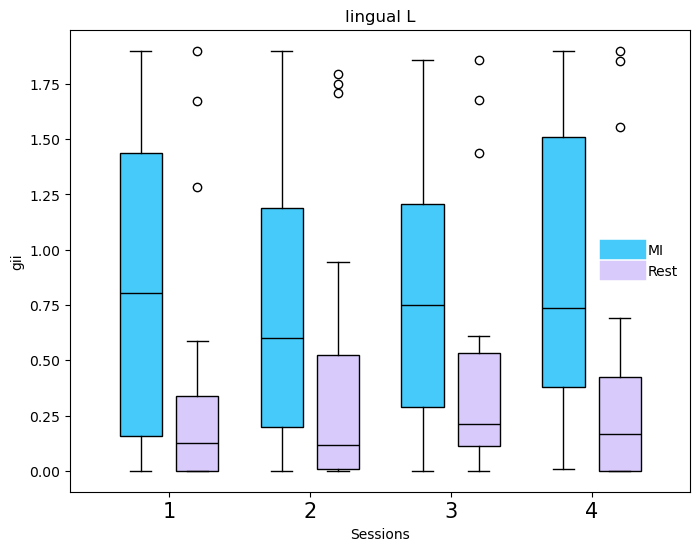

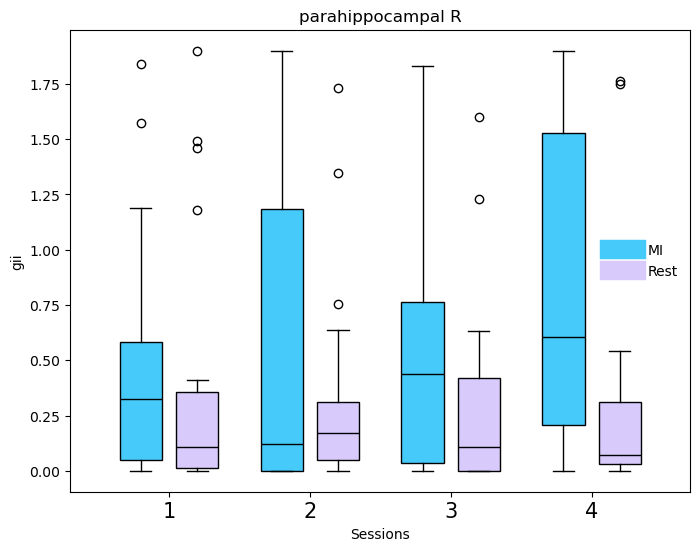

In [14]:
##for gii
for idx_region in gii_idx:
    sessions = range(1, 5)
    mi_values = [x_mi_all[i][idx_region, 1, :] for i in sessions]
    rest_values = [x_rest_all[i][idx_region, 1, :] for i in sessions]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#46CAFA', '#D8CAFA']
    positions = []
    data = []
    box_colors = []

    for i, session in enumerate(sessions):
        positions.append(i-0.2) 
        data.append(mi_values[i])   
        box_colors.append(colors[0])
        
        positions.append(i+0.2) 
        data.append(rest_values[i])
        box_colors.append(colors[1])


    box = ax.boxplot(
        data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
    )


    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f"{all_regions[idx_region]}")
    ax.set_xlabel("Sessions")
    ax.set_ylabel("gii")
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels([str(s) for s in sessions], fontsize=15)
    ax.grid(False)

    legend_patches = [
        plt.Line2D([0], [0], color=colors[0], lw=14, label="MI"),
        plt.Line2D([0], [0], color=colors[1], lw=14, label="Rest")
    ]
    ax.legend(handles=legend_patches, frameon=False)

    plt.show()


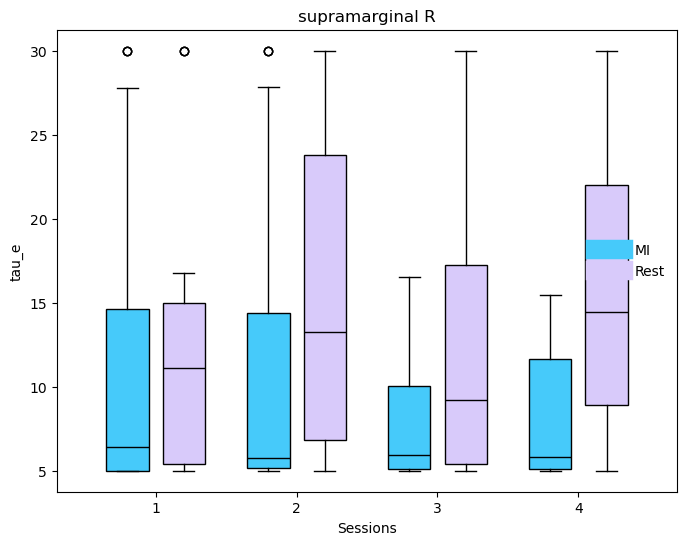

In [ ]:

for idx_region in tau_e_idx:
    sessions = range(1, 5)
    mi_values = [x_mi_all[i][idx_region, 2, :] for i in sessions]
    rest_values = [x_rest_all[i][idx_region, 2, :] for i in sessions]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#46CAFA', '#D8CAFA']
    positions = []
    data = []
    box_colors = []

    for i, session in enumerate(sessions):
        positions.append(i-0.2) 
        data.append(mi_values[i])   
        box_colors.append(colors[0])
        
        positions.append(i+0.2) 
        data.append(rest_values[i])
        box_colors.append(colors[1])


    box = ax.boxplot(
        data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
    )
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f"{all_regions[idx_region]}")
    ax.set_xlabel("Sessions")
    ax.set_ylabel("tau_e")
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels([str(s) for s in sessions])
    ax.grid(False)

    legend_patches = [
        plt.Line2D([0], [0], color=colors[0], lw=14, label="MI"),
        plt.Line2D([0], [0], color=colors[1], lw=14, label="Rest")
    ]
    ax.legend(handles=legend_patches, frameon=False)

    plt.show()


In [16]:
for idx, region in enumerate(all_regions):
    print(idx, all_regions[idx])

0 bankssts L
1 bankssts R
2 caudalanteriorcingulate L
3 caudalanteriorcingulate R
4 caudalmiddlefrontal L
5 caudalmiddlefrontal R
6 cuneus L
7 cuneus R
8 entorhinal L
9 entorhinal R
10 frontalpole L
11 frontalpole R
12 fusiform L
13 fusiform R
14 inferiorparietal L
15 inferiorparietal R
16 inferiortemporal L
17 inferiortemporal R
18 insula L
19 insula R
20 isthmuscingulate L
21 isthmuscingulate R
22 lateraloccipital L
23 lateraloccipital R
24 lateralorbitofrontal L
25 lateralorbitofrontal R
26 lingual L
27 lingual R
28 medialorbitofrontal L
29 medialorbitofrontal R
30 middletemporal L
31 middletemporal R
32 paracentral L
33 paracentral R
34 parahippocampal L
35 parahippocampal R
36 parsopercularis L
37 parsopercularis R
38 parsorbitalis L
39 parsorbitalis R
40 parstriangularis L
41 parstriangularis R
42 pericalcarine L
43 pericalcarine R
44 postcentral L
45 postcentral R
46 posteriorcingulate L
47 posteriorcingulate R
48 precentral L
49 precentral R
50 precuneus L
51 precuneus R
52 ros

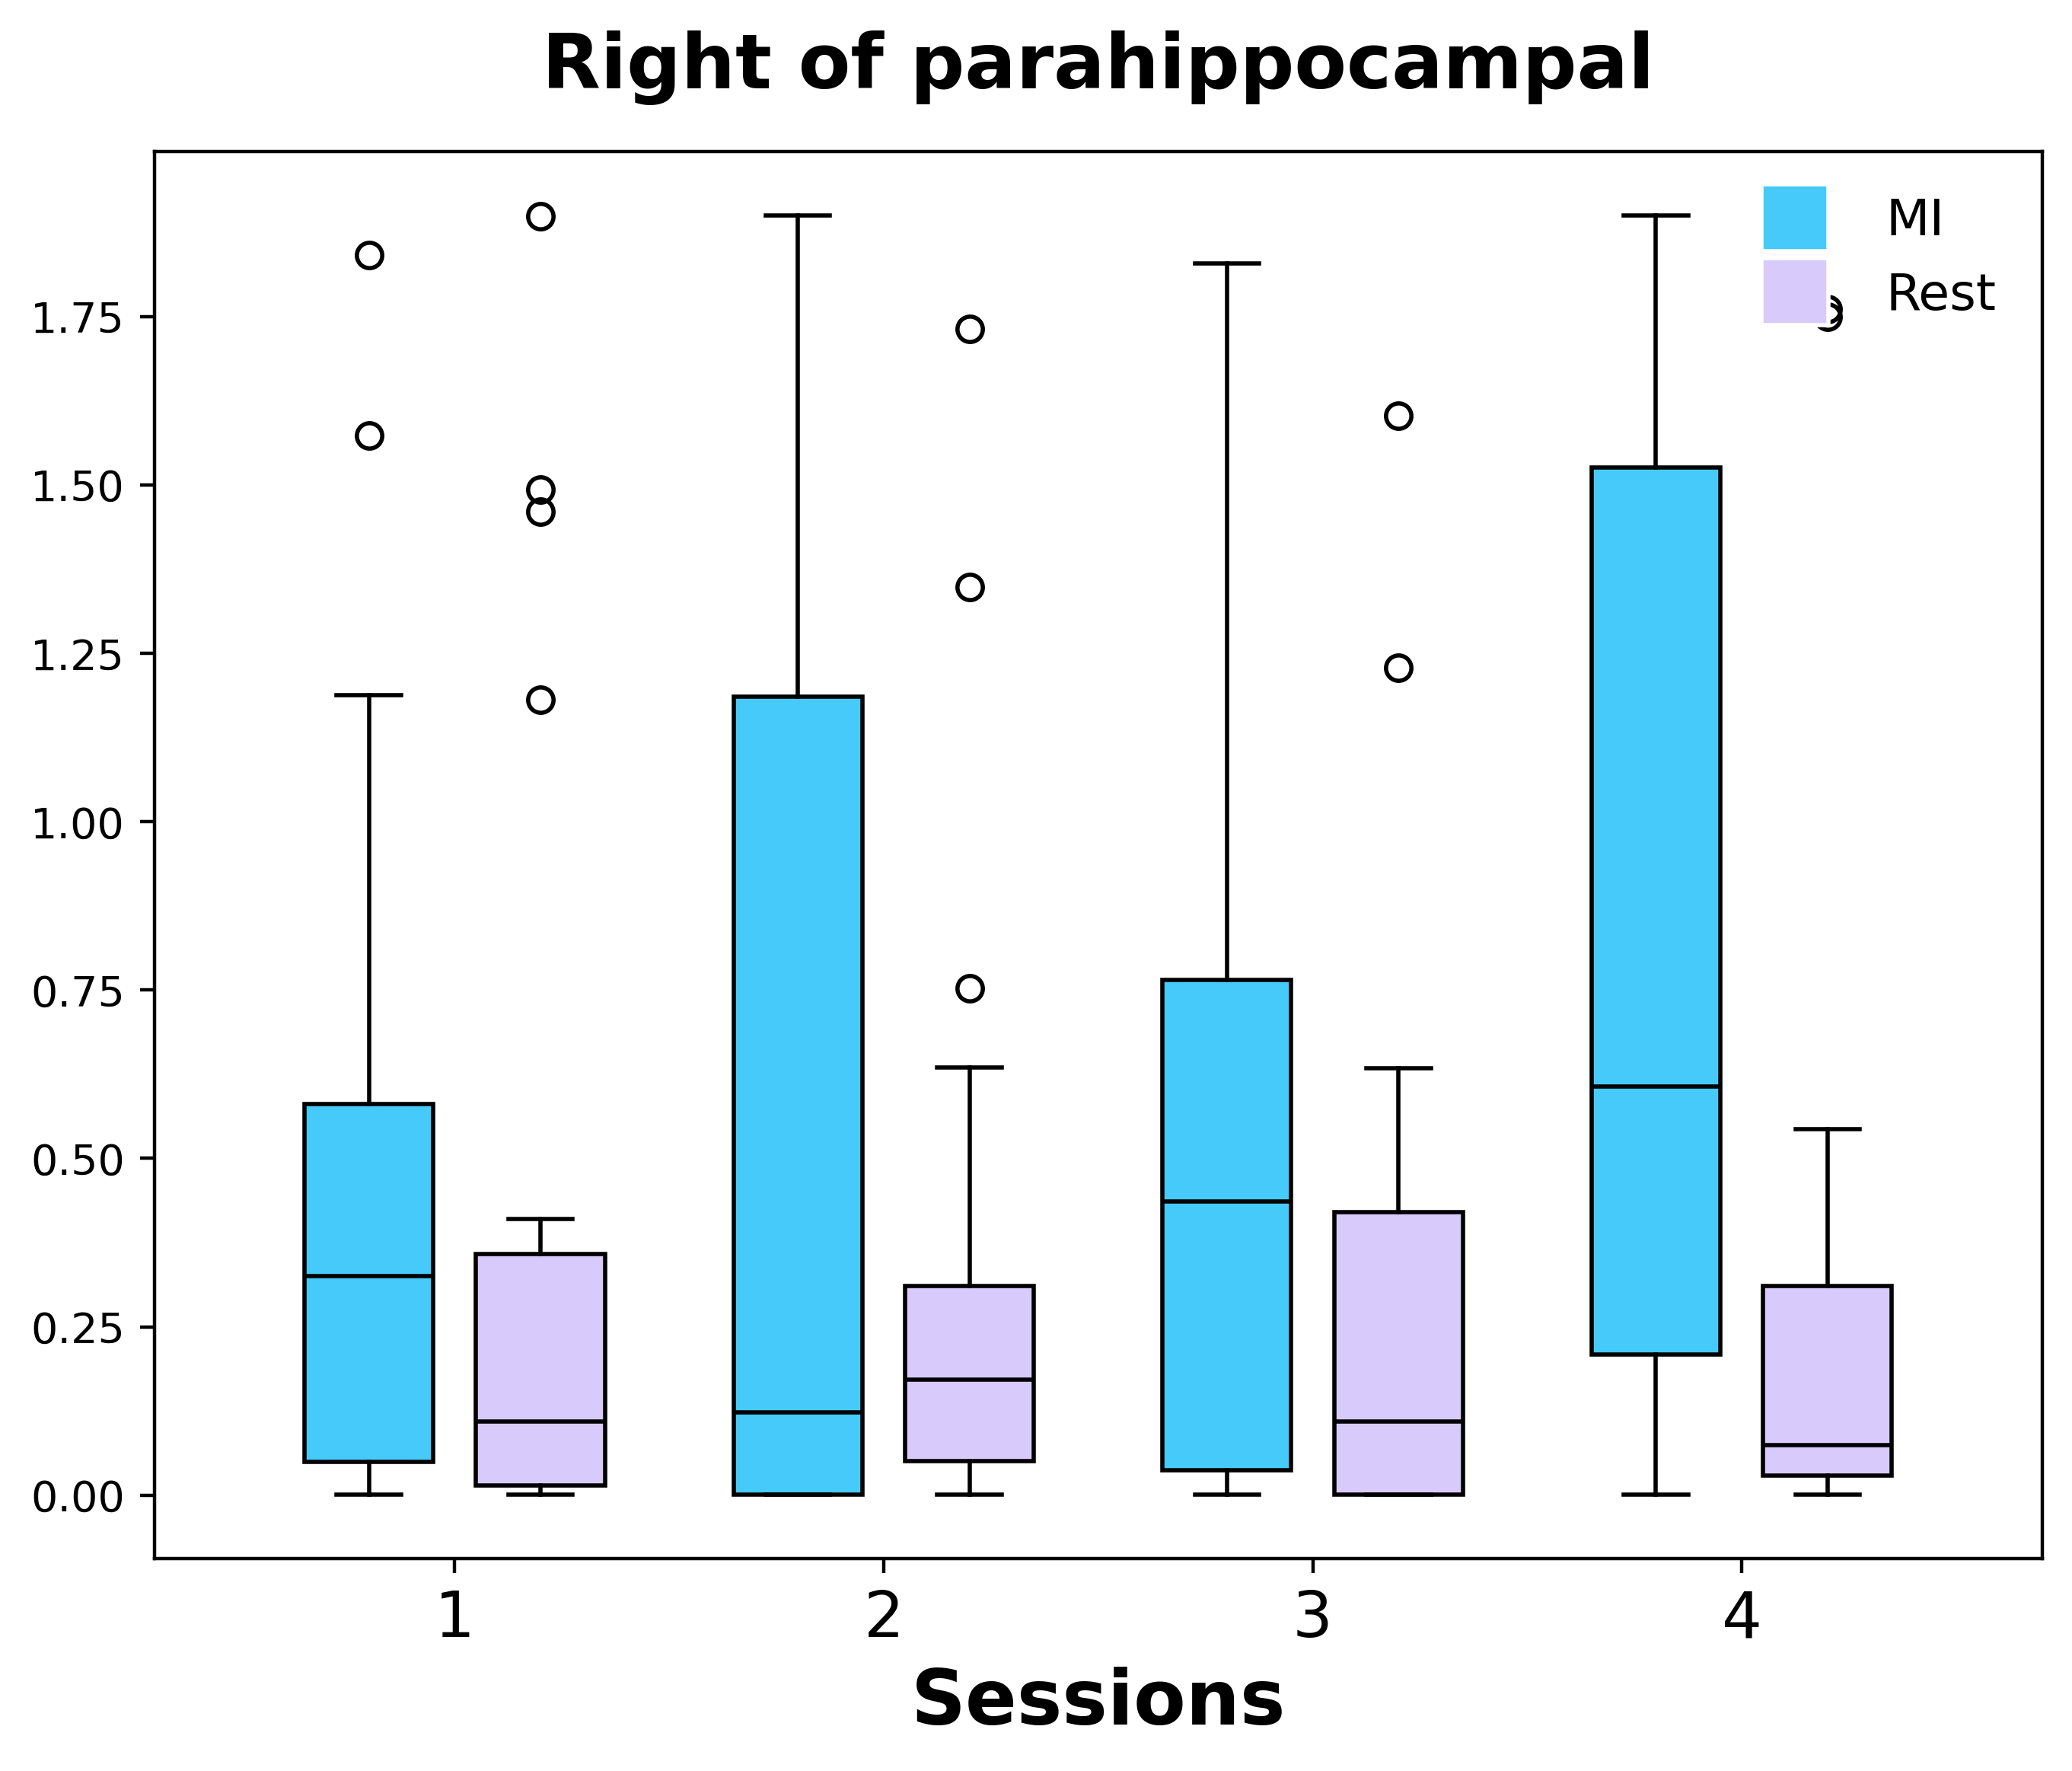

In [22]:
##IMPORTANT REGION
##for gii

sessions = range(1, 5)
mi_values = [x_mi_all[i][35, 1, :] for i in sessions]
rest_values = [x_rest_all[i][35, 1, :] for i in sessions]

fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
colors = ['#46CAFA', '#D8CAFA']
positions = []
data = []
box_colors = []

for i, session in enumerate(sessions):
    positions.append(i-0.2) 
    data.append(mi_values[i])   
    box_colors.append(colors[0])
    
    positions.append(i+0.2) 
    data.append(rest_values[i])
    box_colors.append(colors[1])


box = ax.boxplot(
    data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
)


for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

ax.set_title(f"Right of {all_regions[35][:-2]}", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Sessions", fontsize=18, fontweight="bold")
# ax.set_ylabel("tau_e")
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels([str(s) for s in sessions],fontsize=15)
ax.grid(False)

legend_patches = [
    plt.Line2D([0], [0], marker='s', color='w', markersize=16, markerfacecolor=colors[0], label="MI"),
    plt.Line2D([0], [0], marker='s', color='w', markersize=16, markerfacecolor=colors[1], label="Rest")
]
ax.legend(handles=legend_patches, frameon=False, loc="upper right", fontsize=12)

plt.show()


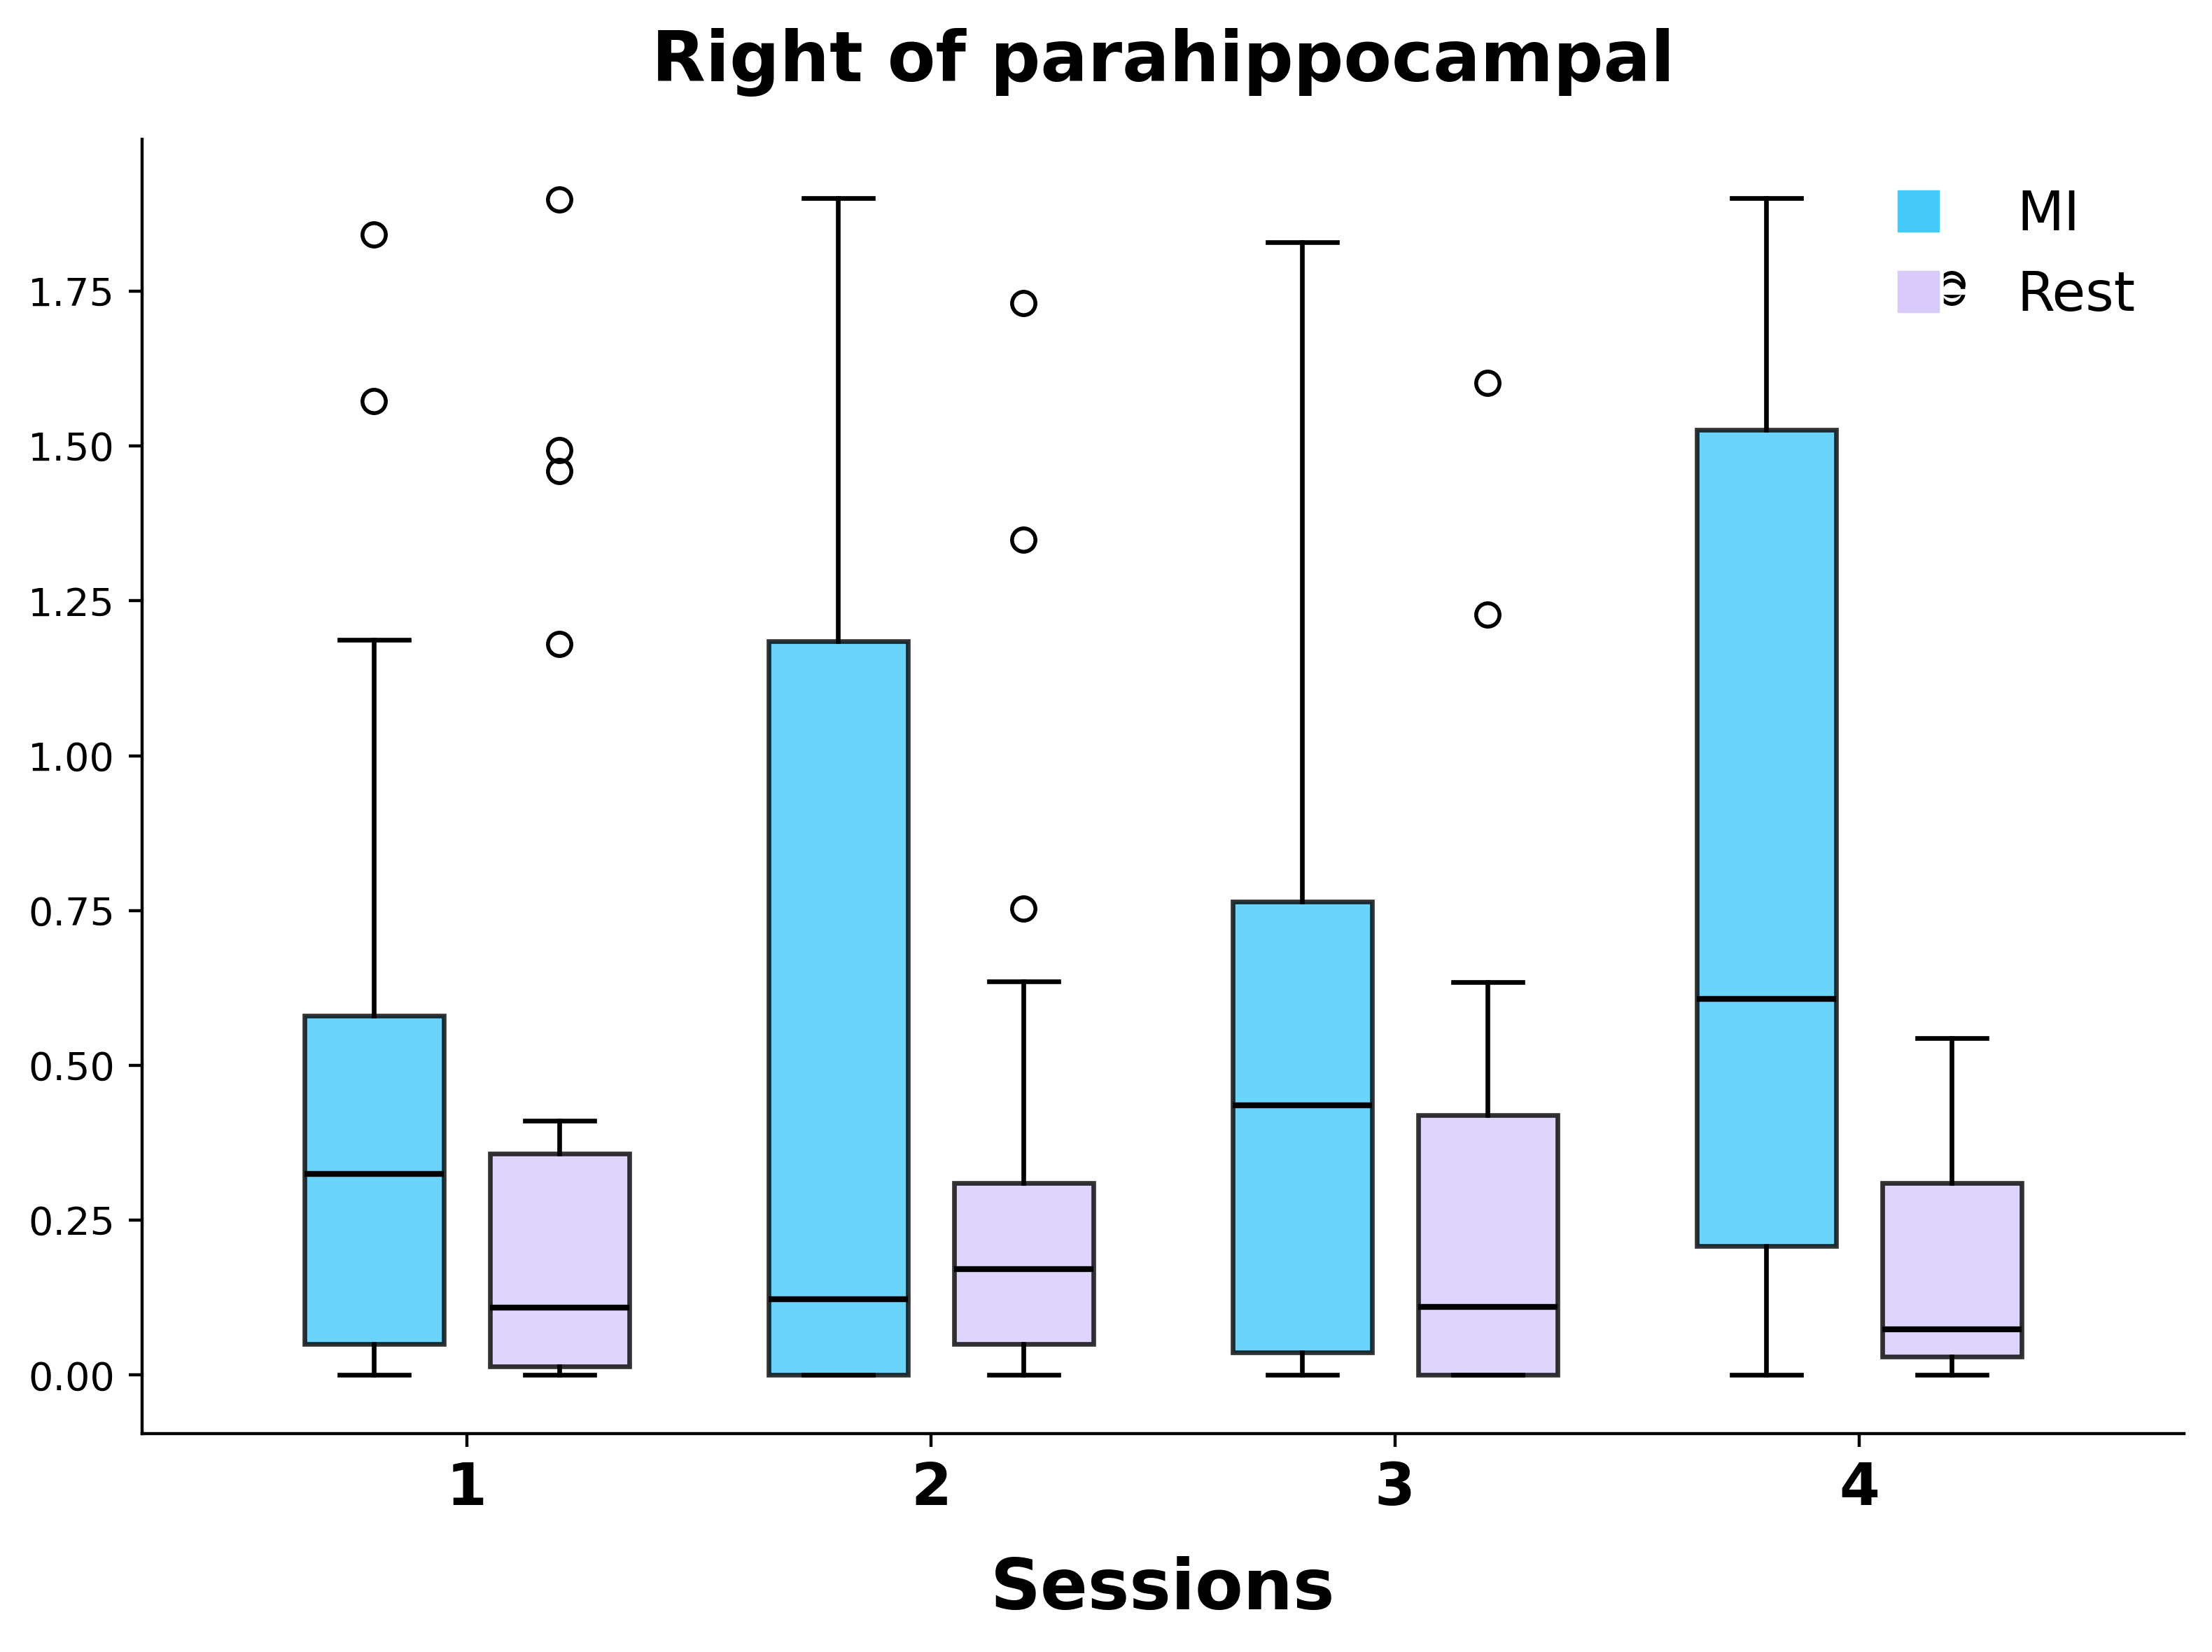

In [23]:
sessions = range(1, 5)
mi_values = [x_mi_all[i][35, 1, :] for i in sessions]
rest_values = [x_rest_all[i][35, 1, :] for i in sessions]

fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

colors = ['#46CAFA', '#D8CAFA'] 
positions = []
data = []
box_colors = []

for i, session in enumerate(sessions):
    positions.append(i - 0.2)  
    data.append(mi_values[i])
    box_colors.append(colors[0])

    positions.append(i + 0.2)  
    data.append(rest_values[i])
    box_colors.append(colors[1])

box = ax.boxplot(
    data, positions=positions, patch_artist=True, widths=0.3,
    medianprops={'color': 'black', 'linewidth': 1.5},
    whiskerprops={'linewidth': 1.2},
    capprops={'linewidth': 1.2},
    boxprops={'linewidth': 1.2}
)


for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)  

ax.set_title(f"Right of {all_regions[35][:-2]}", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Sessions", fontsize=18, fontweight="bold", labelpad=10)
# ax.set_ylabel("Metric Value", fontsize=14, fontweight="bold", labelpad=10)


ax.set_xticks(range(len(sessions)))
ax.set_xticklabels([str(s) for s in sessions], fontsize=15, fontweight="bold")

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_patches = [
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[0], label="MI"),
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[1], label="Rest")
]
ax.legend(handles=legend_patches, frameon=False, loc="upper right", fontsize=14)
plt.tight_layout()
plt.show()
